In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                            | 0/60000 [00:00<?, ?it/s]

 12%|███████▋                                                      | 7472/60000 [00:00<00:00, 74713.48it/s]

 25%|███████████████▏                                             | 14944/60000 [00:00<00:00, 69330.52it/s]

 37%|██████████████████████▋                                      | 22317/60000 [00:00<00:00, 71257.21it/s]

 50%|██████████████████████████████▎                              | 29804/60000 [00:00<00:00, 72646.10it/s]

 62%|█████████████████████████████████████▊                       | 37191/60000 [00:00<00:00, 73079.19it/s]

 74%|█████████████████████████████████████████████▎               | 44511/60000 [00:00<00:00, 72712.94it/s]

 87%|████████████████████████████████████████████████████▉        | 52050/60000 [00:00<00:00, 73576.35it/s]

 99%|████████████████████████████████████████████████████████████▌| 59573/60000 [00:00<00:00, 74096.12it/s]

100%|█████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 72988.00it/s]

  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 65%|████████████████████████████████████████▏                     | 6491/10000 [00:00<00:00, 64904.34it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 65130.46it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 dqkmlnla


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/750 [00:00<?, ?it/s]

  0%|                                                                      | 1/750 [00:00<07:28,  1.67it/s]

  1%|▎                                                                     | 4/750 [00:00<01:45,  7.05it/s]

  1%|▋                                                                     | 7/750 [00:00<01:02, 11.83it/s]

  1%|▉                                                                    | 10/750 [00:00<00:46, 15.88it/s]

  2%|█▏                                                                   | 13/750 [00:01<00:38, 19.15it/s]

  2%|█▍                                                                   | 16/750 [00:01<00:33, 21.71it/s]

  3%|█▋                                                                   | 19/750 [00:01<00:30, 23.61it/s]

  3%|██                                                                   | 22/750 [00:01<00:29, 24.93it/s]

  3%|██▎                                                                  | 25/750 [00:01<00:27, 25.92it/s]

  4%|██▌                                                                  | 28/750 [00:01<00:27, 26.66it/s]

  4%|██▊                                                                  | 31/750 [00:01<00:26, 27.17it/s]

  5%|███▏                                                                 | 34/750 [00:01<00:25, 27.54it/s]

  5%|███▍                                                                 | 37/750 [00:01<00:25, 27.82it/s]

  5%|███▋                                                                 | 40/750 [00:01<00:25, 28.00it/s]

  6%|███▉                                                                 | 43/750 [00:02<00:25, 28.14it/s]

  6%|████▏                                                                | 46/750 [00:02<00:24, 28.24it/s]

  7%|████▌                                                                | 49/750 [00:02<00:24, 28.30it/s]

  7%|████▊                                                                | 52/750 [00:02<00:24, 28.35it/s]

  7%|█████                                                                | 55/750 [00:02<00:24, 28.37it/s]

  8%|█████▎                                                               | 58/750 [00:02<00:24, 28.40it/s]

  8%|█████▌                                                               | 61/750 [00:02<00:24, 28.42it/s]

  9%|█████▉                                                               | 64/750 [00:02<00:24, 28.43it/s]

  9%|██████▏                                                              | 67/750 [00:02<00:24, 28.43it/s]

  9%|██████▍                                                              | 70/750 [00:03<00:23, 28.44it/s]

 10%|██████▋                                                              | 73/750 [00:03<00:23, 28.44it/s]

 10%|██████▉                                                              | 76/750 [00:03<00:23, 28.46it/s]

 11%|███████▎                                                             | 79/750 [00:03<00:23, 28.47it/s]

 11%|███████▌                                                             | 82/750 [00:03<00:23, 28.46it/s]

 11%|███████▊                                                             | 85/750 [00:03<00:23, 28.46it/s]

 12%|████████                                                             | 88/750 [00:03<00:23, 28.47it/s]

 12%|████████▎                                                            | 91/750 [00:03<00:23, 28.46it/s]

 13%|████████▋                                                            | 94/750 [00:03<00:23, 28.45it/s]

 13%|████████▉                                                            | 97/750 [00:03<00:22, 28.45it/s]

 13%|█████████                                                           | 100/750 [00:04<00:22, 28.47it/s]

 14%|█████████▎                                                          | 103/750 [00:04<00:22, 28.48it/s]

 14%|█████████▌                                                          | 106/750 [00:04<00:22, 28.46it/s]

 15%|█████████▉                                                          | 109/750 [00:04<00:22, 28.47it/s]

 15%|██████████▏                                                         | 112/750 [00:04<00:22, 28.47it/s]

 15%|██████████▍                                                         | 115/750 [00:04<00:22, 28.47it/s]

 16%|██████████▋                                                         | 118/750 [00:04<00:22, 28.47it/s]

 16%|██████████▉                                                         | 121/750 [00:04<00:22, 28.46it/s]

 17%|███████████▏                                                        | 124/750 [00:04<00:21, 28.47it/s]

 17%|███████████▌                                                        | 127/750 [00:05<00:21, 28.47it/s]

 17%|███████████▊                                                        | 130/750 [00:05<00:21, 28.48it/s]

 18%|████████████                                                        | 133/750 [00:05<00:21, 28.49it/s]

 18%|████████████▎                                                       | 136/750 [00:05<00:21, 28.38it/s]

 19%|████████████▌                                                       | 139/750 [00:05<00:21, 28.41it/s]

 19%|████████████▊                                                       | 142/750 [00:05<00:21, 28.43it/s]

 19%|█████████████▏                                                      | 145/750 [00:05<00:21, 28.45it/s]

 20%|█████████████▍                                                      | 148/750 [00:05<00:21, 28.45it/s]

 20%|█████████████▋                                                      | 151/750 [00:05<00:21, 28.46it/s]

 21%|█████████████▉                                                      | 154/750 [00:05<00:20, 28.46it/s]

 21%|██████████████▏                                                     | 157/750 [00:06<00:20, 28.46it/s]

 21%|██████████████▌                                                     | 160/750 [00:06<00:20, 28.47it/s]

 22%|██████████████▊                                                     | 163/750 [00:06<00:20, 28.46it/s]

 22%|███████████████                                                     | 166/750 [00:06<00:20, 28.46it/s]

 23%|███████████████▎                                                    | 169/750 [00:06<00:20, 28.47it/s]

 23%|███████████████▌                                                    | 172/750 [00:06<00:20, 28.43it/s]

 23%|███████████████▊                                                    | 175/750 [00:06<00:20, 28.44it/s]

 24%|████████████████▏                                                   | 178/750 [00:06<00:20, 28.45it/s]

 24%|████████████████▍                                                   | 181/750 [00:06<00:19, 28.45it/s]

 25%|████████████████▋                                                   | 184/750 [00:07<00:19, 28.47it/s]

 25%|████████████████▉                                                   | 187/750 [00:07<00:19, 28.48it/s]

 25%|█████████████████▏                                                  | 190/750 [00:07<00:19, 28.48it/s]

 26%|█████████████████▍                                                  | 193/750 [00:07<00:19, 28.47it/s]

 26%|█████████████████▊                                                  | 196/750 [00:07<00:19, 28.47it/s]

 27%|██████████████████                                                  | 199/750 [00:07<00:19, 28.47it/s]

 27%|██████████████████▎                                                 | 202/750 [00:07<00:19, 28.47it/s]

 27%|██████████████████▌                                                 | 205/750 [00:07<00:19, 28.47it/s]

 28%|██████████████████▊                                                 | 208/750 [00:07<00:19, 28.48it/s]

 28%|███████████████████▏                                                | 211/750 [00:07<00:18, 28.48it/s]

 29%|███████████████████▍                                                | 214/750 [00:08<00:18, 28.47it/s]

 29%|███████████████████▋                                                | 217/750 [00:08<00:18, 28.48it/s]

 29%|███████████████████▉                                                | 220/750 [00:08<00:18, 28.47it/s]

 30%|████████████████████▏                                               | 223/750 [00:08<00:18, 28.45it/s]

 30%|████████████████████▍                                               | 226/750 [00:08<00:18, 28.46it/s]

 31%|████████████████████▊                                               | 229/750 [00:08<00:18, 28.48it/s]

 31%|█████████████████████                                               | 232/750 [00:08<00:18, 28.48it/s]

 31%|█████████████████████▎                                              | 235/750 [00:08<00:18, 28.49it/s]

 32%|█████████████████████▌                                              | 238/750 [00:08<00:17, 28.49it/s]

 32%|█████████████████████▊                                              | 241/750 [00:09<00:17, 28.49it/s]

 33%|██████████████████████                                              | 244/750 [00:09<00:17, 28.48it/s]

 33%|██████████████████████▍                                             | 247/750 [00:09<00:17, 28.48it/s]

 33%|██████████████████████▋                                             | 250/750 [00:09<00:17, 28.46it/s]

 34%|██████████████████████▉                                             | 253/750 [00:09<00:17, 28.47it/s]

 34%|███████████████████████▏                                            | 256/750 [00:09<00:17, 28.41it/s]

 35%|███████████████████████▍                                            | 259/750 [00:09<00:17, 28.42it/s]

 35%|███████████████████████▊                                            | 262/750 [00:09<00:17, 28.44it/s]

 35%|████████████████████████                                            | 265/750 [00:09<00:17, 28.45it/s]

 36%|████████████████████████▎                                           | 268/750 [00:09<00:16, 28.46it/s]

 36%|████████████████████████▌                                           | 271/750 [00:10<00:16, 28.47it/s]

 37%|████████████████████████▊                                           | 274/750 [00:10<00:16, 28.47it/s]

 37%|█████████████████████████                                           | 277/750 [00:10<00:16, 28.47it/s]

 37%|█████████████████████████▍                                          | 280/750 [00:10<00:16, 28.47it/s]

 38%|█████████████████████████▋                                          | 283/750 [00:10<00:16, 28.45it/s]

 38%|█████████████████████████▉                                          | 286/750 [00:10<00:16, 28.46it/s]

 39%|██████████████████████████▏                                         | 289/750 [00:10<00:16, 28.46it/s]

 39%|██████████████████████████▍                                         | 292/750 [00:10<00:16, 28.46it/s]

 39%|██████████████████████████▋                                         | 295/750 [00:10<00:15, 28.45it/s]

 40%|███████████████████████████                                         | 298/750 [00:11<00:15, 28.45it/s]

 40%|███████████████████████████▎                                        | 301/750 [00:11<00:15, 28.46it/s]

 41%|███████████████████████████▌                                        | 304/750 [00:11<00:15, 28.45it/s]

 41%|███████████████████████████▊                                        | 307/750 [00:11<00:15, 28.45it/s]

 41%|████████████████████████████                                        | 310/750 [00:11<00:15, 28.46it/s]

 42%|████████████████████████████▍                                       | 313/750 [00:11<00:15, 28.46it/s]

 42%|████████████████████████████▋                                       | 316/750 [00:11<00:15, 28.48it/s]

 43%|████████████████████████████▉                                       | 319/750 [00:11<00:15, 28.47it/s]

 43%|█████████████████████████████▏                                      | 322/750 [00:11<00:15, 28.46it/s]

 43%|█████████████████████████████▍                                      | 325/750 [00:11<00:14, 28.46it/s]

 44%|█████████████████████████████▋                                      | 328/750 [00:12<00:14, 28.46it/s]

 44%|██████████████████████████████                                      | 331/750 [00:12<00:14, 28.46it/s]

 45%|██████████████████████████████▎                                     | 334/750 [00:12<00:14, 28.46it/s]

 45%|██████████████████████████████▌                                     | 337/750 [00:12<00:14, 28.46it/s]

 45%|██████████████████████████████▊                                     | 340/750 [00:12<00:14, 28.47it/s]

 46%|███████████████████████████████                                     | 343/750 [00:12<00:14, 28.33it/s]

 46%|███████████████████████████████▎                                    | 346/750 [00:12<00:14, 28.34it/s]

 47%|███████████████████████████████▋                                    | 349/750 [00:12<00:14, 28.36it/s]

 47%|███████████████████████████████▉                                    | 352/750 [00:12<00:14, 28.38it/s]

 47%|████████████████████████████████▏                                   | 355/750 [00:13<00:13, 28.41it/s]

 48%|████████████████████████████████▍                                   | 358/750 [00:13<00:13, 28.41it/s]

 48%|████████████████████████████████▋                                   | 361/750 [00:13<00:13, 28.43it/s]

 49%|█████████████████████████████████                                   | 364/750 [00:13<00:13, 28.43it/s]

 49%|█████████████████████████████████▎                                  | 367/750 [00:13<00:13, 28.44it/s]

 49%|█████████████████████████████████▌                                  | 370/750 [00:13<00:13, 28.45it/s]

 50%|█████████████████████████████████▊                                  | 373/750 [00:13<00:13, 28.47it/s]

 50%|██████████████████████████████████                                  | 376/750 [00:13<00:13, 28.48it/s]

 51%|██████████████████████████████████▎                                 | 379/750 [00:13<00:13, 28.48it/s]

 51%|██████████████████████████████████▋                                 | 382/750 [00:13<00:12, 28.47it/s]

 51%|██████████████████████████████████▉                                 | 385/750 [00:14<00:12, 28.47it/s]

 52%|███████████████████████████████████▏                                | 388/750 [00:14<00:12, 28.47it/s]

 52%|███████████████████████████████████▍                                | 391/750 [00:14<00:12, 28.45it/s]

 53%|███████████████████████████████████▋                                | 394/750 [00:14<00:12, 28.44it/s]

 53%|███████████████████████████████████▉                                | 397/750 [00:14<00:12, 28.42it/s]

 53%|████████████████████████████████████▎                               | 400/750 [00:14<00:12, 28.40it/s]

 54%|████████████████████████████████████▌                               | 403/750 [00:14<00:12, 28.36it/s]

 54%|████████████████████████████████████▊                               | 406/750 [00:14<00:12, 28.37it/s]

 55%|█████████████████████████████████████                               | 409/750 [00:14<00:12, 28.32it/s]

 55%|█████████████████████████████████████▎                              | 412/750 [00:15<00:11, 28.34it/s]

 55%|█████████████████████████████████████▋                              | 415/750 [00:15<00:11, 28.37it/s]

 56%|█████████████████████████████████████▉                              | 418/750 [00:15<00:11, 28.40it/s]

 56%|██████████████████████████████████████▏                             | 421/750 [00:15<00:11, 28.42it/s]

 57%|██████████████████████████████████████▍                             | 424/750 [00:15<00:11, 28.43it/s]

 57%|██████████████████████████████████████▋                             | 427/750 [00:15<00:11, 28.45it/s]

 57%|██████████████████████████████████████▉                             | 430/750 [00:15<00:11, 28.46it/s]

 58%|███████████████████████████████████████▎                            | 433/750 [00:15<00:11, 28.45it/s]

 58%|███████████████████████████████████████▌                            | 436/750 [00:15<00:11, 28.45it/s]

 59%|███████████████████████████████████████▊                            | 439/750 [00:15<00:10, 28.45it/s]

 59%|████████████████████████████████████████                            | 442/750 [00:16<00:10, 28.46it/s]

 59%|████████████████████████████████████████▎                           | 445/750 [00:16<00:10, 28.46it/s]

 60%|████████████████████████████████████████▌                           | 448/750 [00:16<00:10, 28.47it/s]

 60%|████████████████████████████████████████▉                           | 451/750 [00:16<00:10, 28.47it/s]

 61%|█████████████████████████████████████████▏                          | 454/750 [00:16<00:10, 28.46it/s]

 61%|█████████████████████████████████████████▍                          | 457/750 [00:16<00:10, 28.47it/s]

 61%|█████████████████████████████████████████▋                          | 460/750 [00:16<00:10, 28.49it/s]

 62%|█████████████████████████████████████████▉                          | 463/750 [00:16<00:10, 28.50it/s]

 62%|██████████████████████████████████████████▎                         | 466/750 [00:16<00:09, 28.49it/s]

 63%|██████████████████████████████████████████▌                         | 469/750 [00:17<00:09, 28.49it/s]

 63%|██████████████████████████████████████████▊                         | 472/750 [00:17<00:09, 28.50it/s]

 63%|███████████████████████████████████████████                         | 475/750 [00:17<00:09, 28.51it/s]

 64%|███████████████████████████████████████████▎                        | 478/750 [00:17<00:09, 28.50it/s]

 64%|███████████████████████████████████████████▌                        | 481/750 [00:17<00:09, 28.51it/s]

 65%|███████████████████████████████████████████▉                        | 484/750 [00:17<00:09, 28.52it/s]

 65%|████████████████████████████████████████████▏                       | 487/750 [00:17<00:09, 28.52it/s]

 65%|████████████████████████████████████████████▍                       | 490/750 [00:17<00:09, 28.51it/s]

 66%|████████████████████████████████████████████▋                       | 493/750 [00:17<00:09, 28.51it/s]

 66%|████████████████████████████████████████████▉                       | 496/750 [00:17<00:08, 28.50it/s]

 67%|█████████████████████████████████████████████▏                      | 499/750 [00:18<00:08, 28.49it/s]

 67%|█████████████████████████████████████████████▌                      | 502/750 [00:18<00:08, 28.48it/s]

 67%|█████████████████████████████████████████████▊                      | 505/750 [00:18<00:08, 28.49it/s]

 68%|██████████████████████████████████████████████                      | 508/750 [00:18<00:08, 28.49it/s]

 68%|██████████████████████████████████████████████▎                     | 511/750 [00:18<00:08, 28.46it/s]

 69%|██████████████████████████████████████████████▌                     | 514/750 [00:18<00:08, 28.48it/s]

 69%|██████████████████████████████████████████████▊                     | 517/750 [00:18<00:08, 28.49it/s]

 69%|███████████████████████████████████████████████▏                    | 520/750 [00:18<00:08, 28.50it/s]

 70%|███████████████████████████████████████████████▍                    | 523/750 [00:18<00:07, 28.50it/s]

 70%|███████████████████████████████████████████████▋                    | 526/750 [00:19<00:07, 28.49it/s]

 71%|███████████████████████████████████████████████▉                    | 529/750 [00:19<00:07, 28.50it/s]

 71%|████████████████████████████████████████████████▏                   | 532/750 [00:19<00:07, 28.50it/s]

 71%|████████████████████████████████████████████████▌                   | 535/750 [00:19<00:07, 28.34it/s]

 72%|████████████████████████████████████████████████▊                   | 538/750 [00:19<00:07, 28.37it/s]

 72%|█████████████████████████████████████████████████                   | 541/750 [00:19<00:07, 28.42it/s]

 73%|█████████████████████████████████████████████████▎                  | 544/750 [00:19<00:07, 28.44it/s]

 73%|█████████████████████████████████████████████████▌                  | 547/750 [00:19<00:07, 28.46it/s]

 73%|█████████████████████████████████████████████████▊                  | 550/750 [00:19<00:07, 28.47it/s]

 74%|██████████████████████████████████████████████████▏                 | 553/750 [00:19<00:06, 28.49it/s]

 74%|██████████████████████████████████████████████████▍                 | 556/750 [00:20<00:06, 28.49it/s]

 75%|██████████████████████████████████████████████████▋                 | 559/750 [00:20<00:06, 28.50it/s]

 75%|██████████████████████████████████████████████████▉                 | 562/750 [00:20<00:06, 28.51it/s]

 75%|███████████████████████████████████████████████████▏                | 565/750 [00:20<00:06, 28.50it/s]

 76%|███████████████████████████████████████████████████▍                | 568/750 [00:20<00:06, 28.48it/s]

 76%|███████████████████████████████████████████████████▊                | 571/750 [00:20<00:06, 28.48it/s]

 77%|████████████████████████████████████████████████████                | 574/750 [00:20<00:06, 28.46it/s]

 77%|████████████████████████████████████████████████████▎               | 577/750 [00:20<00:06, 28.49it/s]

 77%|████████████████████████████████████████████████████▌               | 580/750 [00:20<00:05, 28.49it/s]

 78%|████████████████████████████████████████████████████▊               | 583/750 [00:21<00:05, 28.50it/s]

 78%|█████████████████████████████████████████████████████▏              | 586/750 [00:21<00:05, 28.50it/s]

 79%|█████████████████████████████████████████████████████▍              | 589/750 [00:21<00:05, 28.38it/s]

 79%|█████████████████████████████████████████████████████▋              | 592/750 [00:21<00:05, 28.38it/s]

 79%|█████████████████████████████████████████████████████▉              | 595/750 [00:21<00:05, 28.42it/s]

 80%|██████████████████████████████████████████████████████▏             | 598/750 [00:21<00:05, 28.44it/s]

 80%|██████████████████████████████████████████████████████▍             | 601/750 [00:21<00:05, 28.45it/s]

 81%|██████████████████████████████████████████████████████▊             | 604/750 [00:21<00:05, 28.47it/s]

 81%|███████████████████████████████████████████████████████             | 607/750 [00:21<00:05, 28.48it/s]

 81%|███████████████████████████████████████████████████████▎            | 610/750 [00:21<00:04, 28.49it/s]

 82%|███████████████████████████████████████████████████████▌            | 613/750 [00:22<00:04, 28.49it/s]

 82%|███████████████████████████████████████████████████████▊            | 616/750 [00:22<00:04, 28.49it/s]

 83%|████████████████████████████████████████████████████████            | 619/750 [00:22<00:04, 28.49it/s]

 83%|████████████████████████████████████████████████████████▍           | 622/750 [00:22<00:04, 28.48it/s]

 83%|████████████████████████████████████████████████████████▋           | 625/750 [00:22<00:04, 28.49it/s]

 84%|████████████████████████████████████████████████████████▉           | 628/750 [00:22<00:04, 28.50it/s]

 84%|█████████████████████████████████████████████████████████▏          | 631/750 [00:22<00:04, 28.51it/s]

 85%|█████████████████████████████████████████████████████████▍          | 634/750 [00:22<00:04, 28.50it/s]

 85%|█████████████████████████████████████████████████████████▊          | 637/750 [00:22<00:03, 28.49it/s]

 85%|██████████████████████████████████████████████████████████          | 640/750 [00:23<00:03, 28.50it/s]

 86%|██████████████████████████████████████████████████████████▎         | 643/750 [00:23<00:03, 28.47it/s]

 86%|██████████████████████████████████████████████████████████▌         | 646/750 [00:23<00:03, 28.44it/s]

 87%|██████████████████████████████████████████████████████████▊         | 649/750 [00:23<00:03, 28.48it/s]

 87%|███████████████████████████████████████████████████████████         | 652/750 [00:23<00:03, 28.49it/s]

 87%|███████████████████████████████████████████████████████████▍        | 655/750 [00:23<00:03, 28.49it/s]

 88%|███████████████████████████████████████████████████████████▋        | 658/750 [00:23<00:03, 28.49it/s]

 88%|███████████████████████████████████████████████████████████▉        | 661/750 [00:23<00:03, 28.50it/s]

 89%|████████████████████████████████████████████████████████████▏       | 664/750 [00:23<00:03, 28.51it/s]

 89%|████████████████████████████████████████████████████████████▍       | 667/750 [00:23<00:02, 28.50it/s]

 89%|████████████████████████████████████████████████████████████▋       | 670/750 [00:24<00:02, 28.50it/s]

 90%|█████████████████████████████████████████████████████████████       | 673/750 [00:24<00:02, 28.50it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 676/750 [00:24<00:02, 28.49it/s]

 91%|█████████████████████████████████████████████████████████████▌      | 679/750 [00:24<00:02, 28.50it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 682/750 [00:24<00:02, 28.50it/s]

 91%|██████████████████████████████████████████████████████████████      | 685/750 [00:24<00:02, 28.50it/s]

 92%|██████████████████████████████████████████████████████████████▍     | 688/750 [00:24<00:02, 28.50it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 691/750 [00:24<00:02, 28.50it/s]

 93%|██████████████████████████████████████████████████████████████▉     | 694/750 [00:24<00:01, 28.49it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 697/750 [00:25<00:01, 28.48it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 700/750 [00:25<00:01, 28.49it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 703/750 [00:25<00:01, 28.49it/s]

 94%|████████████████████████████████████████████████████████████████    | 706/750 [00:25<00:01, 28.49it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 709/750 [00:25<00:01, 28.49it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 712/750 [00:25<00:01, 28.47it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 715/750 [00:25<00:01, 28.47it/s]

 96%|█████████████████████████████████████████████████████████████████   | 718/750 [00:25<00:01, 28.47it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 721/750 [00:25<00:01, 28.48it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 724/750 [00:25<00:00, 28.48it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 727/750 [00:26<00:00, 28.46it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 730/750 [00:26<00:00, 28.48it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 733/750 [00:26<00:00, 28.49it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 736/750 [00:26<00:00, 28.50it/s]

 99%|███████████████████████████████████████████████████████████████████ | 739/750 [00:26<00:00, 28.50it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 742/750 [00:26<00:00, 28.49it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 745/750 [00:26<00:00, 28.38it/s]

100%|███████████████████████████████████████████████████████████████████▊| 748/750 [00:26<00:00, 28.40it/s]

100%|████████████████████████████████████████████████████████████████████| 750/750 [00:26<00:00, 27.85it/s]

train - OK


  0%|                                                                              | 0/188 [00:00<?, ?it/s]

  1%|▋                                                                     | 2/188 [00:00<00:12, 14.88it/s]

  3%|█▊                                                                    | 5/188 [00:00<00:08, 22.07it/s]

  4%|██▉                                                                   | 8/188 [00:00<00:07, 24.90it/s]

  6%|████                                                                 | 11/188 [00:00<00:06, 26.35it/s]

  7%|█████▏                                                               | 14/188 [00:00<00:06, 27.18it/s]

  9%|██████▏                                                              | 17/188 [00:00<00:06, 27.67it/s]

 11%|███████▎                                                             | 20/188 [00:00<00:05, 28.01it/s]

 12%|████████▍                                                            | 23/188 [00:00<00:05, 28.23it/s]

 14%|█████████▌                                                           | 26/188 [00:00<00:05, 28.36it/s]

 15%|██████████▋                                                          | 29/188 [00:01<00:05, 28.46it/s]

 17%|███████████▋                                                         | 32/188 [00:01<00:05, 28.52it/s]

 19%|████████████▊                                                        | 35/188 [00:01<00:05, 28.58it/s]

 20%|█████████████▉                                                       | 38/188 [00:01<00:05, 28.62it/s]

 22%|███████████████                                                      | 41/188 [00:01<00:05, 28.65it/s]

 23%|████████████████▏                                                    | 44/188 [00:01<00:05, 28.67it/s]

 25%|█████████████████▎                                                   | 47/188 [00:01<00:04, 28.70it/s]

 27%|██████████████████▎                                                  | 50/188 [00:01<00:04, 28.71it/s]

 28%|███████████████████▍                                                 | 53/188 [00:01<00:04, 28.68it/s]

 30%|████████████████████▌                                                | 56/188 [00:02<00:04, 28.69it/s]

 31%|█████████████████████▋                                               | 59/188 [00:02<00:04, 28.71it/s]

 33%|██████████████████████▊                                              | 62/188 [00:02<00:04, 28.71it/s]

 35%|███████████████████████▊                                             | 65/188 [00:02<00:04, 28.70it/s]

 36%|████████████████████████▉                                            | 68/188 [00:02<00:04, 28.70it/s]

 38%|██████████████████████████                                           | 71/188 [00:02<00:04, 28.71it/s]

 39%|███████████████████████████▏                                         | 74/188 [00:02<00:03, 28.71it/s]

 41%|████████████████████████████▎                                        | 77/188 [00:02<00:03, 28.70it/s]

 43%|█████████████████████████████▎                                       | 80/188 [00:02<00:03, 28.72it/s]

 44%|██████████████████████████████▍                                      | 83/188 [00:02<00:03, 28.71it/s]

 46%|███████████████████████████████▌                                     | 86/188 [00:03<00:03, 28.72it/s]

 47%|████████████████████████████████▋                                    | 89/188 [00:03<00:03, 28.72it/s]

 49%|█████████████████████████████████▊                                   | 92/188 [00:03<00:03, 28.71it/s]

 51%|██████████████████████████████████▊                                  | 95/188 [00:03<00:03, 28.72it/s]

 52%|███████████████████████████████████▉                                 | 98/188 [00:03<00:03, 28.71it/s]

 54%|████████████████████████████████████▌                               | 101/188 [00:03<00:03, 28.71it/s]

 55%|█████████████████████████████████████▌                              | 104/188 [00:03<00:02, 28.73it/s]

 57%|██████████████████████████████████████▋                             | 107/188 [00:03<00:02, 28.72it/s]

 59%|███████████████████████████████████████▊                            | 110/188 [00:03<00:02, 28.73it/s]

 60%|████████████████████████████████████████▊                           | 113/188 [00:04<00:02, 28.74it/s]

 62%|█████████████████████████████████████████▉                          | 116/188 [00:04<00:02, 28.60it/s]

 63%|███████████████████████████████████████████                         | 119/188 [00:04<00:02, 28.61it/s]

 65%|████████████████████████████████████████████▏                       | 122/188 [00:04<00:02, 28.64it/s]

 66%|█████████████████████████████████████████████▏                      | 125/188 [00:04<00:02, 28.67it/s]

 68%|██████████████████████████████████████████████▎                     | 128/188 [00:04<00:02, 28.69it/s]

 70%|███████████████████████████████████████████████▍                    | 131/188 [00:04<00:01, 28.70it/s]

 71%|████████████████████████████████████████████████▍                   | 134/188 [00:04<00:01, 28.71it/s]

 73%|█████████████████████████████████████████████████▌                  | 137/188 [00:04<00:01, 28.70it/s]

 74%|██████████████████████████████████████████████████▋                 | 140/188 [00:04<00:01, 28.70it/s]

 76%|███████████████████████████████████████████████████▋                | 143/188 [00:05<00:01, 28.70it/s]

 78%|████████████████████████████████████████████████████▊               | 146/188 [00:05<00:01, 28.72it/s]

 79%|█████████████████████████████████████████████████████▉              | 149/188 [00:05<00:01, 28.73it/s]

 81%|██████████████████████████████████████████████████████▉             | 152/188 [00:05<00:01, 28.72it/s]

 82%|████████████████████████████████████████████████████████            | 155/188 [00:05<00:01, 28.70it/s]

 84%|█████████████████████████████████████████████████████████▏          | 158/188 [00:05<00:01, 28.70it/s]

 86%|██████████████████████████████████████████████████████████▏         | 161/188 [00:05<00:00, 28.70it/s]

 87%|███████████████████████████████████████████████████████████▎        | 164/188 [00:05<00:00, 28.73it/s]

 89%|████████████████████████████████████████████████████████████▍       | 167/188 [00:05<00:00, 28.71it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 170/188 [00:05<00:00, 28.70it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 173/188 [00:06<00:00, 28.72it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 176/188 [00:06<00:00, 28.72it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 179/188 [00:06<00:00, 28.77it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 182/188 [00:06<00:00, 28.65it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 185/188 [00:06<00:00, 28.66it/s]

100%|████████████████████████████████████████████████████████████████████| 188/188 [00:06<00:00, 27.33it/s]

100%|████████████████████████████████████████████████████████████████████| 188/188 [00:06<00:00, 28.24it/s]

val - OK


  0%|                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▍                                                                     | 1/157 [00:00<00:16,  9.61it/s]

  3%|█▊                                                                    | 4/157 [00:00<00:07, 20.65it/s]

  4%|███                                                                   | 7/157 [00:00<00:06, 24.23it/s]

  6%|████▍                                                                | 10/157 [00:00<00:05, 25.93it/s]

  8%|█████▋                                                               | 13/157 [00:00<00:05, 26.88it/s]

 10%|███████                                                              | 16/157 [00:00<00:05, 27.46it/s]

 12%|████████▎                                                            | 19/157 [00:00<00:04, 27.82it/s]

 14%|█████████▋                                                           | 22/157 [00:00<00:04, 28.06it/s]

 16%|██████████▉                                                          | 25/157 [00:00<00:04, 28.21it/s]

 18%|████████████▎                                                        | 28/157 [00:01<00:04, 28.31it/s]

 20%|█████████████▌                                                       | 31/157 [00:01<00:04, 28.38it/s]

 22%|██████████████▉                                                      | 34/157 [00:01<00:04, 28.44it/s]

 24%|████████████████▎                                                    | 37/157 [00:01<00:04, 28.48it/s]

 25%|█████████████████▌                                                   | 40/157 [00:01<00:04, 28.51it/s]

 27%|██████████████████▉                                                  | 43/157 [00:01<00:03, 28.52it/s]

 29%|████████████████████▏                                                | 46/157 [00:01<00:03, 28.54it/s]

 31%|█████████████████████▌                                               | 49/157 [00:01<00:03, 28.54it/s]

 33%|██████████████████████▊                                              | 52/157 [00:01<00:03, 28.55it/s]

 35%|████████████████████████▏                                            | 55/157 [00:01<00:03, 28.56it/s]

 37%|█████████████████████████▍                                           | 58/157 [00:02<00:03, 28.54it/s]

 39%|██████████████████████████▊                                          | 61/157 [00:02<00:03, 28.54it/s]

 41%|████████████████████████████▏                                        | 64/157 [00:02<00:03, 28.52it/s]

 43%|█████████████████████████████▍                                       | 67/157 [00:02<00:03, 28.54it/s]

 45%|██████████████████████████████▊                                      | 70/157 [00:02<00:03, 28.54it/s]

 46%|████████████████████████████████                                     | 73/157 [00:02<00:02, 28.54it/s]

 48%|█████████████████████████████████▍                                   | 76/157 [00:02<00:02, 28.56it/s]

 50%|██████████████████████████████████▋                                  | 79/157 [00:02<00:02, 28.56it/s]

 52%|████████████████████████████████████                                 | 82/157 [00:02<00:02, 28.57it/s]

 54%|█████████████████████████████████████▎                               | 85/157 [00:03<00:02, 28.58it/s]

 56%|██████████████████████████████████████▋                              | 88/157 [00:03<00:02, 28.60it/s]

 58%|███████████████████████████████████████▉                             | 91/157 [00:03<00:02, 28.60it/s]

 60%|█████████████████████████████████████████▎                           | 94/157 [00:03<00:02, 28.60it/s]

 62%|██████████████████████████████████████████▋                          | 97/157 [00:03<00:02, 28.64it/s]

 64%|███████████████████████████████████████████▎                        | 100/157 [00:03<00:01, 28.64it/s]

 66%|████████████████████████████████████████████▌                       | 103/157 [00:03<00:01, 28.64it/s]

 68%|█████████████████████████████████████████████▉                      | 106/157 [00:03<00:01, 28.61it/s]

 69%|███████████████████████████████████████████████▏                    | 109/157 [00:03<00:01, 28.61it/s]

 71%|████████████████████████████████████████████████▌                   | 112/157 [00:03<00:01, 28.61it/s]

 73%|█████████████████████████████████████████████████▊                  | 115/157 [00:04<00:01, 28.61it/s]

 75%|███████████████████████████████████████████████████                 | 118/157 [00:04<00:01, 28.61it/s]

 77%|████████████████████████████████████████████████████▍               | 121/157 [00:04<00:01, 28.62it/s]

 79%|█████████████████████████████████████████████████████▋              | 124/157 [00:04<00:01, 28.66it/s]

 81%|███████████████████████████████████████████████████████             | 127/157 [00:04<00:01, 28.68it/s]

 83%|████████████████████████████████████████████████████████▎           | 130/157 [00:04<00:00, 28.67it/s]

 85%|█████████████████████████████████████████████████████████▌          | 133/157 [00:04<00:00, 28.68it/s]

 87%|██████████████████████████████████████████████████████████▉         | 136/157 [00:04<00:00, 28.66it/s]

 89%|████████████████████████████████████████████████████████████▏       | 139/157 [00:04<00:00, 28.67it/s]

 90%|█████████████████████████████████████████████████████████████▌      | 142/157 [00:05<00:00, 28.68it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 145/157 [00:05<00:00, 28.70it/s]

 94%|████████████████████████████████████████████████████████████████    | 148/157 [00:05<00:00, 28.69it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 151/157 [00:05<00:00, 28.69it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 154/157 [00:05<00:00, 28.67it/s]

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.66it/s]

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.04it/s]

test InD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  4%|██▊                                                                   | 4/100 [00:00<00:02, 32.34it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:02, 32.34it/s]

 12%|████████▎                                                            | 12/100 [00:00<00:02, 32.36it/s]

 16%|███████████                                                          | 16/100 [00:00<00:02, 32.36it/s]

 20%|█████████████▊                                                       | 20/100 [00:00<00:02, 32.36it/s]

 24%|████████████████▌                                                    | 24/100 [00:00<00:02, 32.36it/s]

 28%|███████████████████▎                                                 | 28/100 [00:00<00:02, 32.37it/s]

 32%|██████████████████████                                               | 32/100 [00:00<00:02, 32.35it/s]

 36%|████████████████████████▊                                            | 36/100 [00:01<00:01, 32.35it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:01<00:01, 32.35it/s]

 44%|██████████████████████████████▎                                      | 44/100 [00:01<00:01, 32.36it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:01<00:01, 32.37it/s]

 52%|███████████████████████████████████▉                                 | 52/100 [00:01<00:01, 32.36it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:01<00:01, 32.36it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:01<00:01, 32.35it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:01<00:01, 32.35it/s]

 68%|██████████████████████████████████████████████▉                      | 68/100 [00:02<00:00, 32.35it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:02<00:00, 32.36it/s]

 76%|████████████████████████████████████████████████████▍                | 76/100 [00:02<00:00, 32.33it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:02<00:00, 32.34it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:02<00:00, 32.34it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:02<00:00, 32.36it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [00:02<00:00, 32.36it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:02<00:00, 32.36it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.36it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.35it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(48000, 1, 32, 32) (48000, 256) (48000, 768) (48000, 1, 32, 32) (48000,)
(12000, 1, 32, 32) (12000, 256) (12000, 768) (12000, 1, 32, 32) (12000,)
(10000, 1, 32, 32) (10000, 256) (10000, 768) (10000, 1, 32, 32) (10000,)
(6400, 1, 32, 32) (6400, 256) (6400, 768) (6400, 1, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


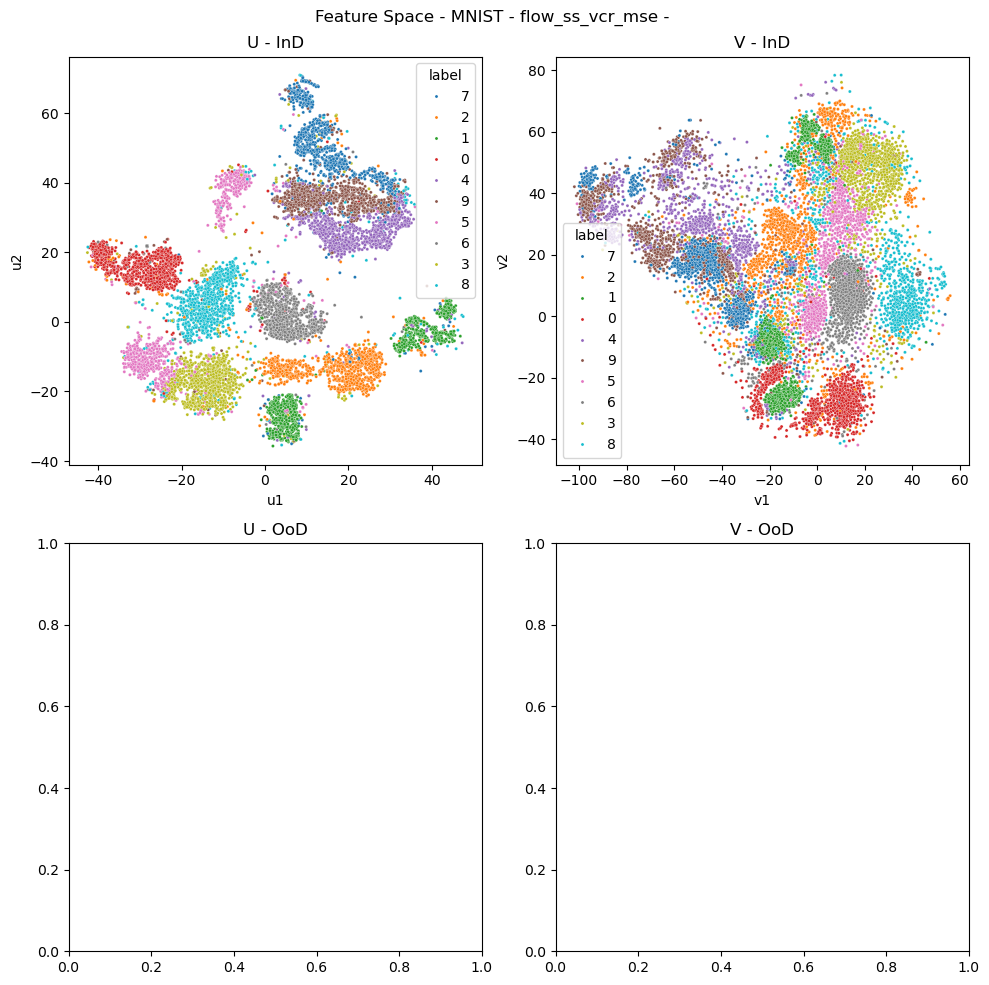

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  1.93it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:01<00:01,  1.92it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  1.66it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.23s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.24s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.25s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.28s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.27s/it]

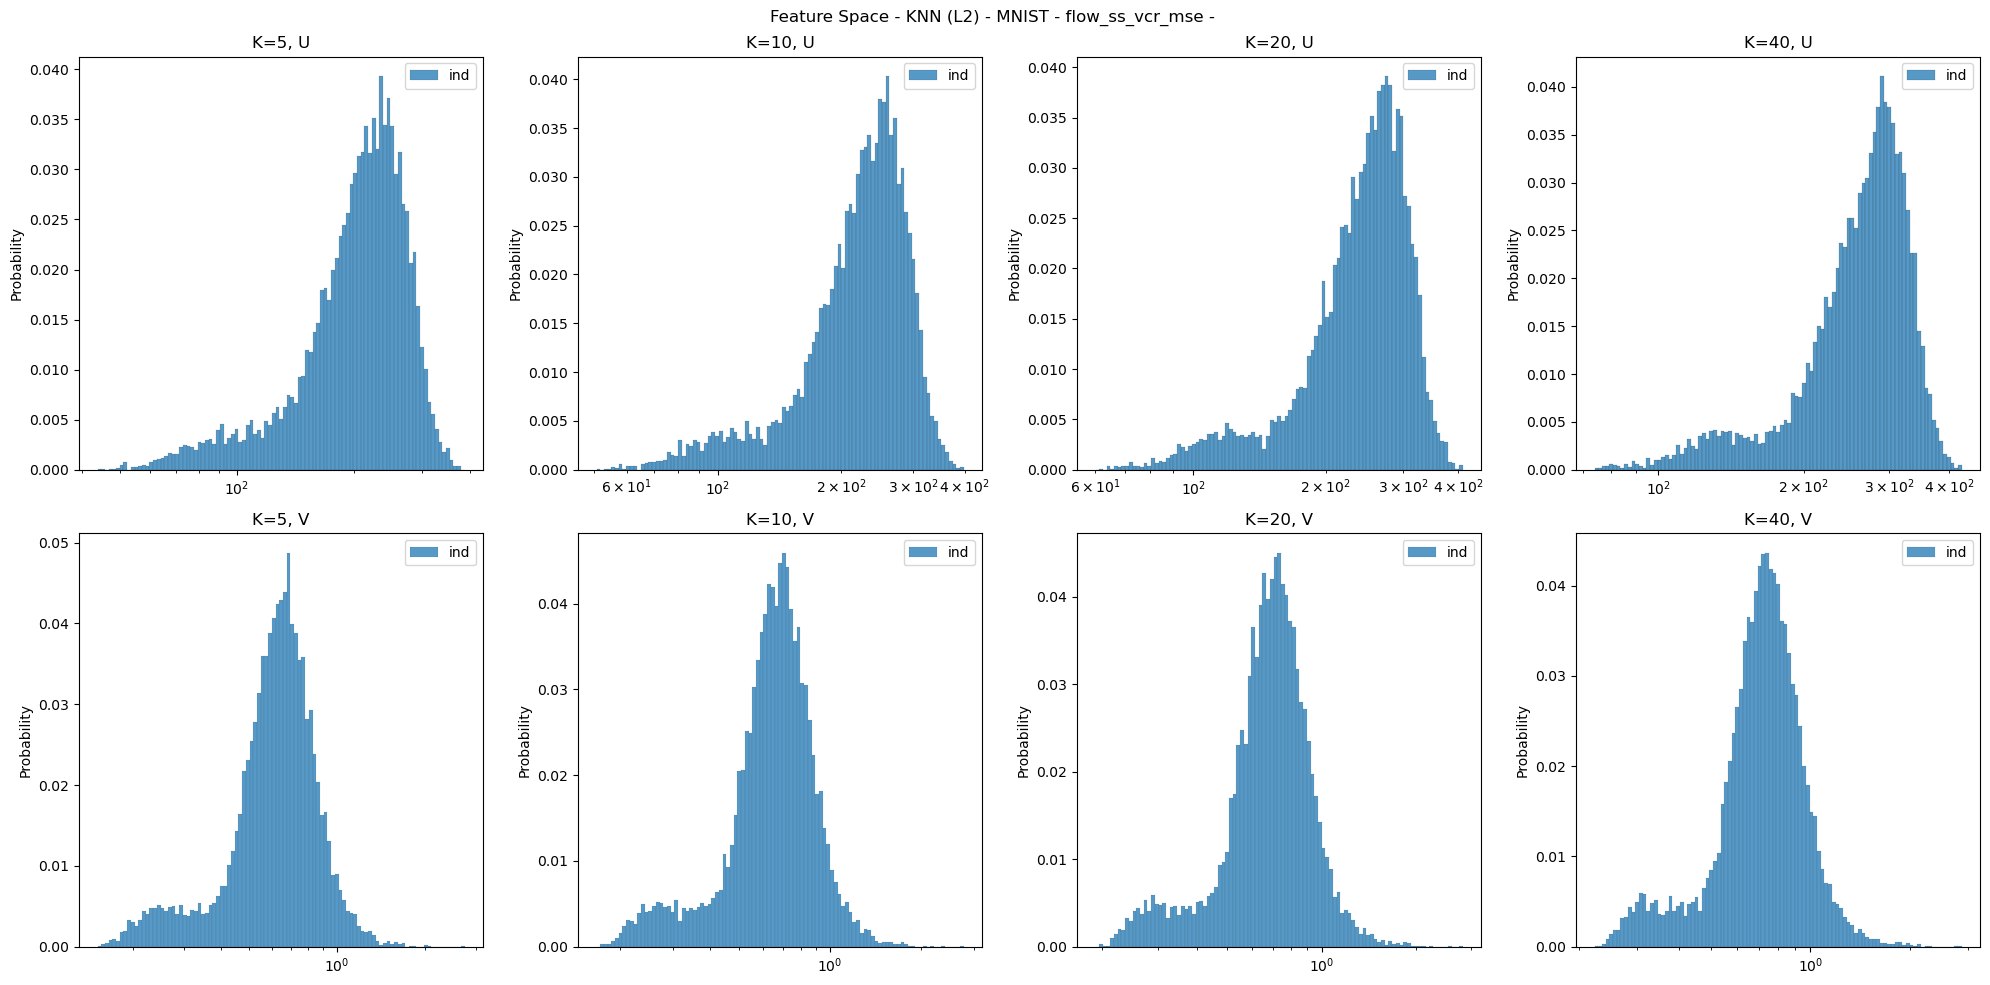

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.01it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:01,  2.00it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  1.95it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:04,  1.40s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.30s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.28s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.29s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.29s/it]

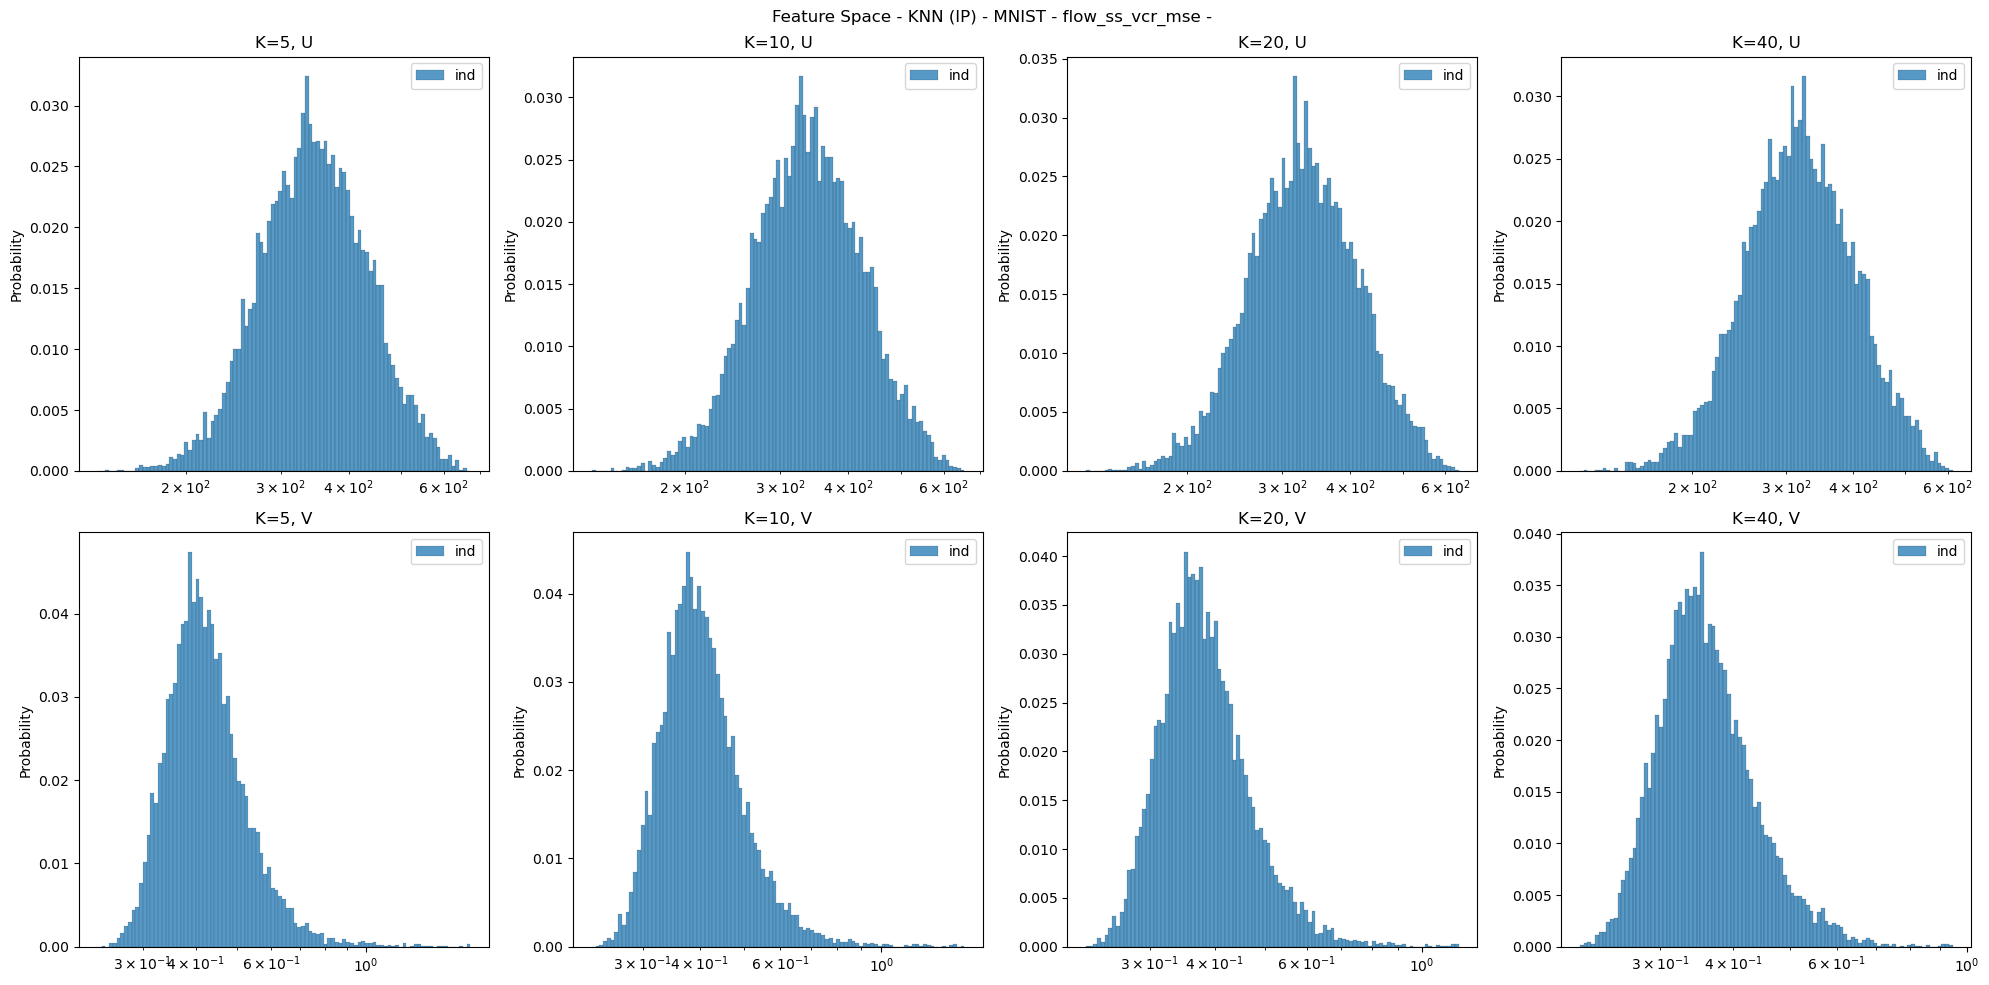

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

20.764647 2.0693614 0.86476505 0.11511357
20.711374 2.0542889 0.86737067 0.11654209
20.851255 2.0567877 0.86098146 0.112062685
34.584736 2.122789 26.533218 0.7996889


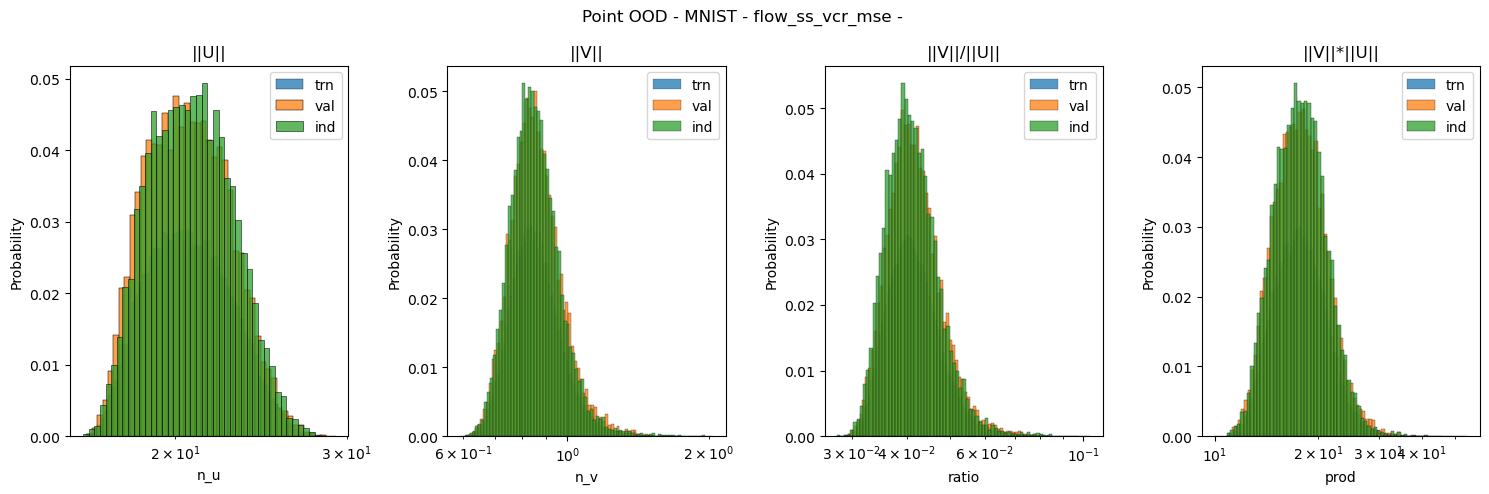

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


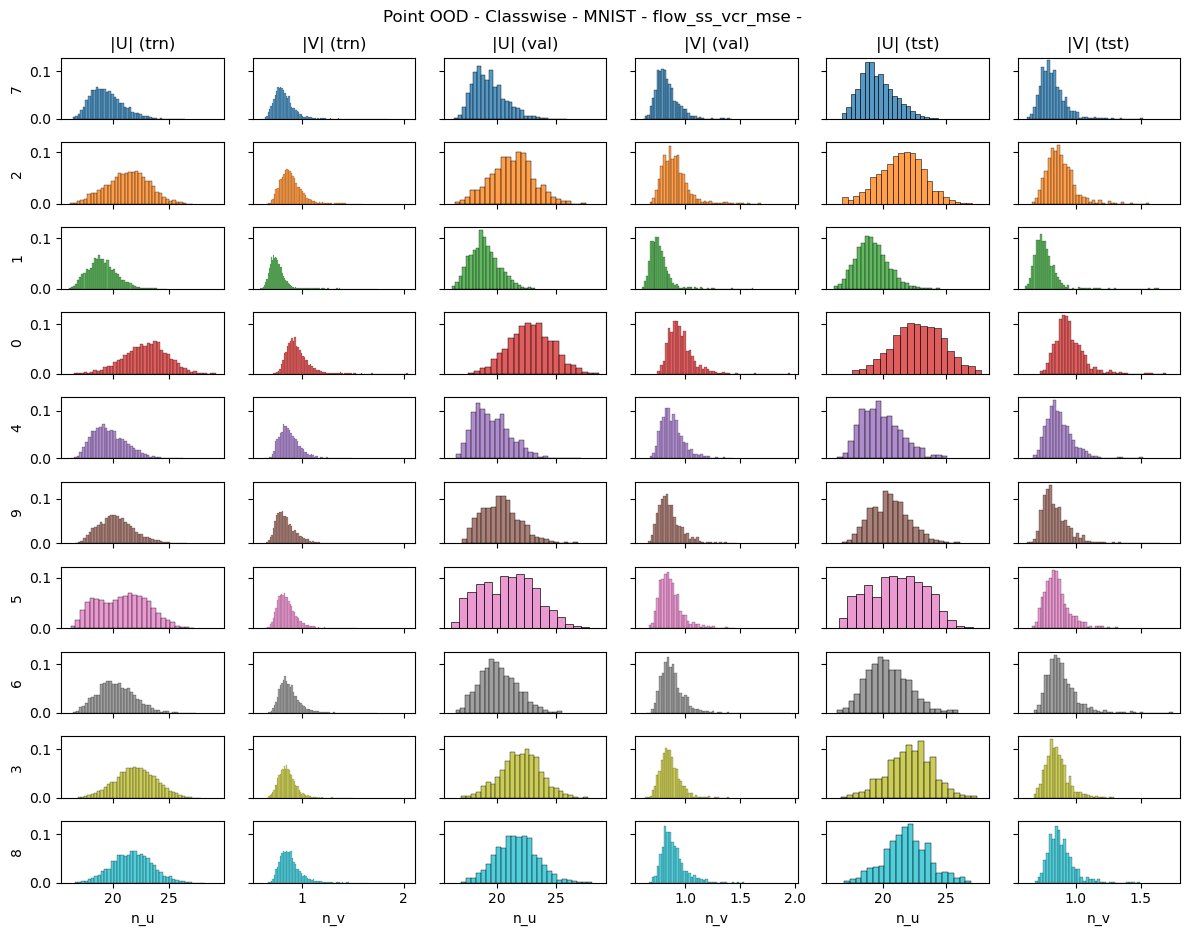

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

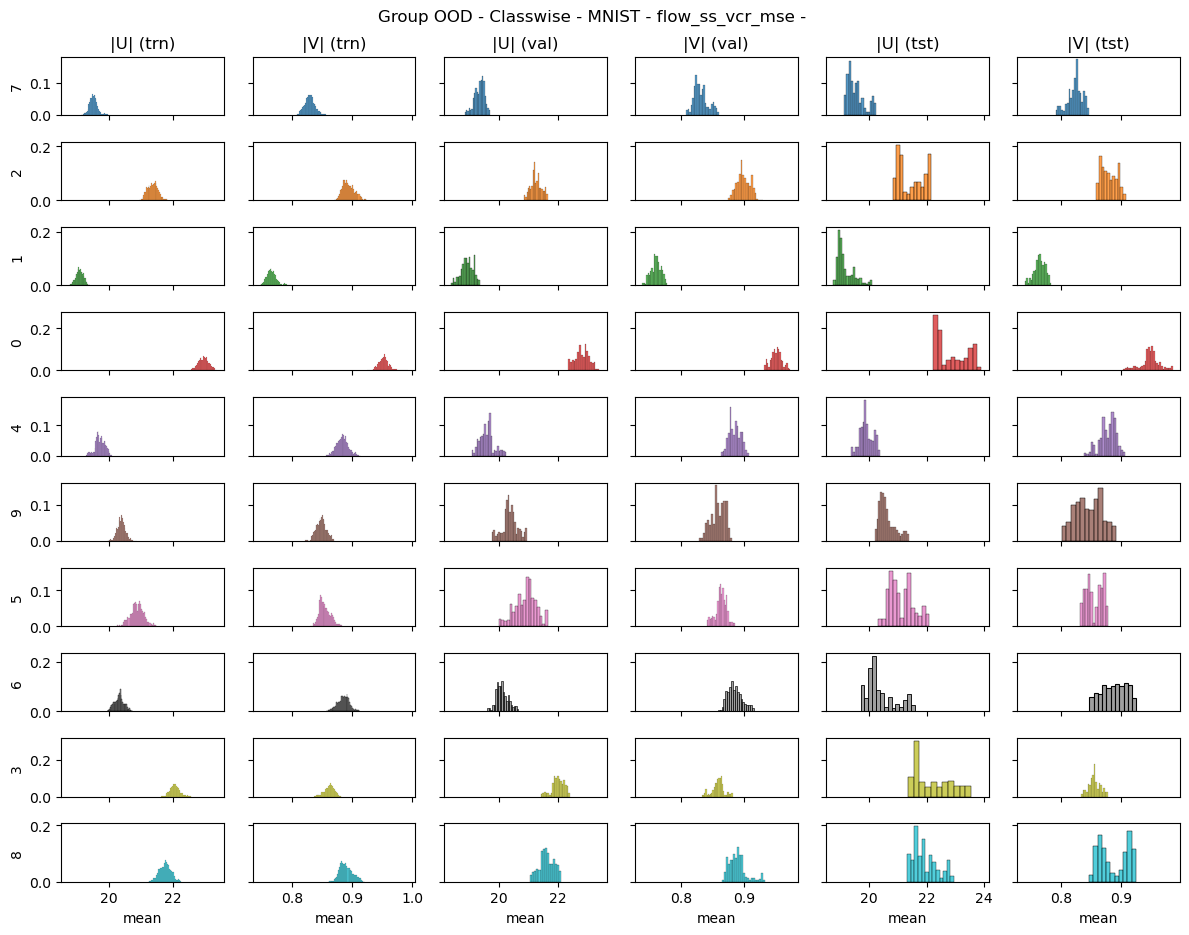

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

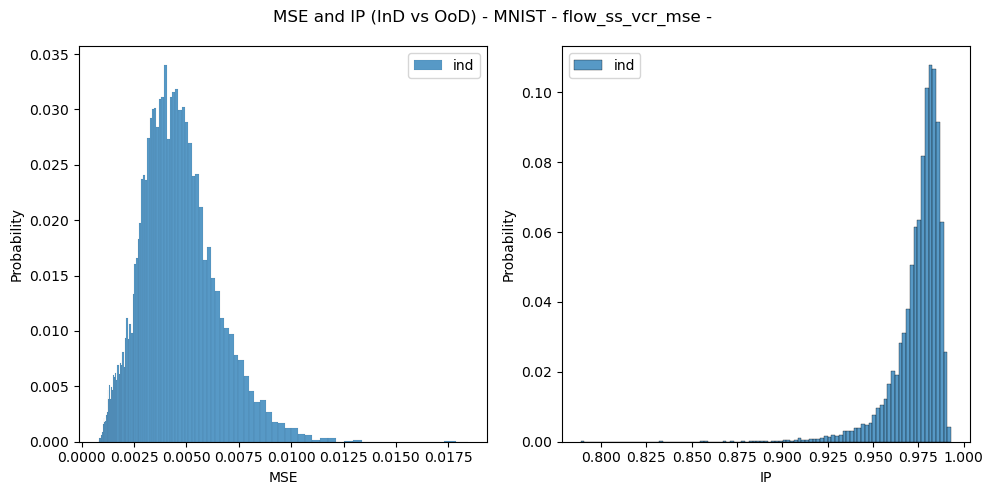

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()